# Neural ODE

In [16]:
# TODO: Replace print with logging

# see https://towardsdatascience.com/deep-study-of-a-not-very-deep-neural-network-part-2-activation-functions-fd9bd8d406fc

# Plot all activation function together to visually see the differences.
# Comment on which that is differentable and whoes not - What is the pros of treating a differentable/non-differentable activation function?


# Make all plots possible to save
# Move all parameters to params.py file, that we load into the run script/notebook
# then, create a main script that run all the different models, and save the model object after training.

### 1. SETUP

Import useful packages and pre-defined helper functions

In [17]:
import torch
import torch.nn as nn

import utilities as utilities
import params as params

Set parameters

In [18]:
# Model Activation Functions
activation_functions = [
    nn.ReLU,
    nn.Sigmoid,
    nn.SiLU,
    nn.Tanh,
    nn.ELU,
    nn.Hardsigmoid,
    nn.GELU,
]

# Model Optimizer
model_optimizer = torch.optim.SGD

# Model Loss Function
model_lossfn = nn.BCELoss
# NOTE: nn.BCELoss has no sigmoid built-in
# Require inputs to have gone through the sigmoid activation function prior

In [19]:
model_kwargs = params.shallow_kwargs_dict["Shallow Euler UT m=p"]

hidden_dim = model_kwargs[
    "hidden_dim"
]  # NOTE: hvis hidden dim er for stor, blir det da for vanskelig å plotte trajectory som "ligner" på slik input dataen er i 2D?
hidden_internal_dim = model_kwargs[
    "hidden_internal_dim"
]  # internal dim in y' : p in (p x m)
num_hidden_layers = model_kwargs["num_hidden_layers"]  # number of time steps
method = model_kwargs["method"]  # ["neural", "euler", "rk4"][1]
variant = model_kwargs["variant"]  # ["standard", "UT"][1]

print(
    f"Used model kwargs for {model_kwargs['name']}: \n"
    f"\tMETHOD: {method}\n"
    f"\tVARIANT: {variant}\n"
    f"\t# time steps: {num_hidden_layers}\n"
    f"\tm dim: {hidden_dim}\n"
    f"\tp dim: {hidden_internal_dim}\n"
)

Used model kwargs for Shallow Euler UT ODE w/ m=p: 
	METHOD: euler
	VARIANT: UT
	# time steps: 3
	m dim: 18
	p dim: 18



### 2. Data Preparation

#### 2.1 Load and prepare dataset

In [20]:
dataset_type = params.dataset_types[0]

Shape of synthetic dataset (X, y): (torch.Size([4000, 2]), torch.Size([4000]))


/Users/martineh/anaconda3/envs/resnet/lib/python3.9/site-packages/matplotlib/collections.py:1109: UserWarning:

Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.



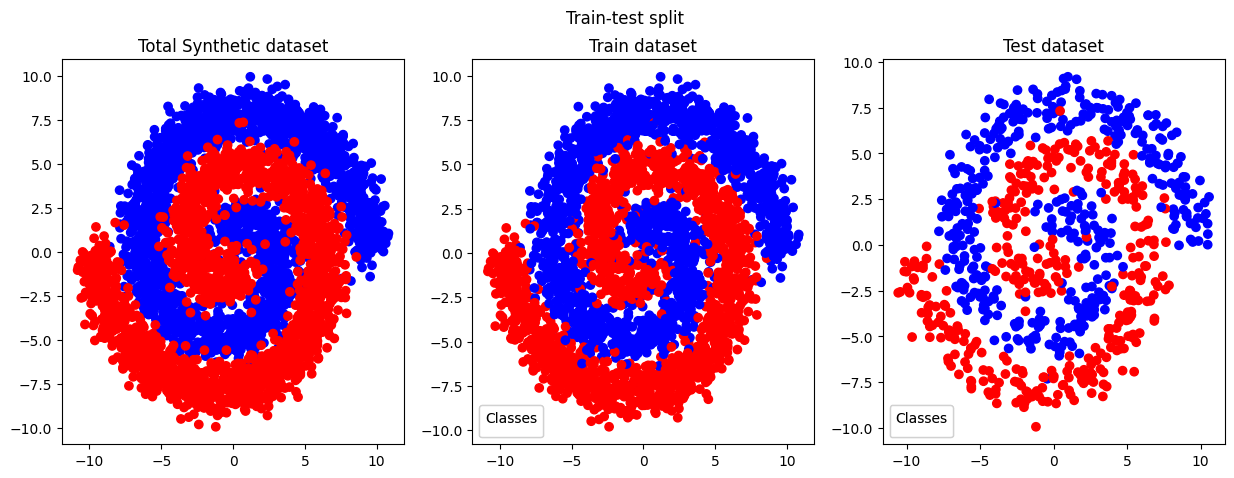

In [21]:
# Load dataset (X, y)
if dataset_type == "spiral":
    # Sprial data
    X, y = utilities.generate_spiral_data(params.n_points, noise=0.8, degree=540)

elif dataset_type == "circle":
    # Circle data
    X, y = utilities.generate_circle_data(params.n_points, noise=0.1, factor=0.8)

else:
    raise ValueError(
        f"Dataset type {dataset_type} is not defined. Please try another type!"
    )

# Load to torch tensor
# Train test split
(
    train_dataloader,
    test_dataloader,
    train_data,
    test_data,
    X_train,
    y_train,
    X_test,
    y_test,
) = utilities.get_dataloader_from_numpy_dataset(
    X, y, plot_splitting=True, color_label_dict=params.color_label_dict
)

#### 2.2 Get dim of data

In [22]:
# Get dim
input_dim = X.shape[-1]
if len(y.shape) == 1:
    output_dim = 1
else:
    output_dim = y.shape[-1]

print(f"dim of input data: {input_dim}")
print(f"dim of output data: {output_dim}")

dim of input data: 2
dim of output data: 1


### 3. Neural ODE Implementation

In [23]:
class ODEBlock(nn.Module):
    """
    y' = dy/dt

    Args:
        nn (_type_): _description_
    """

    def __init__(self, variant, sigma, m, p=None):
        super(ODEBlock, self).__init__()
        self.variant = variant
        self.m = m
        self.p = p if p else m  # Default to m if p is None
        self.sigma = sigma  # activation function

        if self.variant == "standard":
            self.W = nn.Parameter(torch.randn(self.m, self.m))
            self.b = nn.Parameter(torch.randn(self.m))
        elif self.variant == "UT":
            self.U = nn.Parameter(torch.randn(self.p, self.m))
            self.W = nn.Parameter(torch.randn(self.p, self.m))
            self.b = nn.Parameter(torch.randn(self.p))
        else:
            raise ValueError("Invalid variant type")

    def forward(self, y):
        # y shape : batch size x m

        if self.variant == "standard":
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]), self.b)
            return self.sigma(Wy + b)  # torch.mm : matrix multiplication
        elif self.variant == "UT":
            Wy = torch.mm(self.W, y.T).T
            b = torch.mul(torch.ones(y.shape[0], self.b.shape[0]), self.b)
            # print(self.sigma(Wy + b).shape, self.U.shape)
            # print(Wy, b)
            return torch.mm(self.U.T, self.sigma(Wy + b).T).T


class NeuralODE(nn.Module):
    """

    FIXME: What about multiple steps?

    Args:
        nn (_type_): _description_
    """

    def __init__(
        self,
        input_dim,
        hidden_dim,
        hidden_internal_dim,
        output_dim,
        num_hidden_layers,
        sigma,
        method,
        variant,
    ):
        super(NeuralODE, self).__init__()
        self.method = method
        self.variant = variant
        self.num_hidden_layers = num_hidden_layers  # how many time steps
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_internal_dim = hidden_internal_dim
        self.output_dim = output_dim
        self.sigma = sigma()
        self.h = 0.05  # constant step size

        self.input_layer = nn.Linear(
            in_features=input_dim, out_features=hidden_dim, bias=False
        )

        self.ode = ODEBlock(
            variant=variant, sigma=self.sigma, m=hidden_dim, p=hidden_internal_dim
        )  # y'

        self.classifier = nn.Linear(in_features=hidden_dim, out_features=output_dim)

        # logits to prob
        self.logits_to_prob = nn.Sigmoid()

    def forward(self, x):
        # track transformation of the data
        # samples in batch - num hidden units - num hidden layers + 1 # FIXME: Do i need +1??
        x_transformed = torch.empty(
            x.shape[0], self.hidden_dim, self.num_hidden_layers + 1
        )

        # input layer (increase dimension)
        x = self.input_layer(x)

        # save tranformation of x at time t0 (after dim increase)
        x_transformed[:, :, 0] = x

        # ODE solver
        for t in range(self.num_hidden_layers):  # how many time steps
            if self.method == "neural":
                x = self.ode(x)
            elif self.method == "euler":
                x = x + self.h * self.ode(x)
            elif self.method == "rk4":
                k1 = self.ode(x)
                k2 = self.ode(x + self.h * k1 / 2.0)
                k3 = self.ode(x + self.h * k2 / 2.0)
                k4 = self.ode(x + self.h * k3)

                x = x + self.h * (k1 + 2.0 * k2 + 2.0 * k3 + k4) / 6.0

            else:
                raise ValueError("Invalid method type")

            # save tranformation of x for each time step
            x_transformed[:, :, t + 1] = x

        # outout layers
        # classifier to binary channel
        # and from logits to probabilities
        x = self.classifier(x)
        x = self.logits_to_prob(x)

        return x.squeeze(), x_transformed

### 4. Training

In [24]:
# NOTE:
# med spiral dataset fungerer hidden_dim = 3, og man kan da plotte resultatet i 3d. Nettverket fungerer ikke for cirkel data.


# ut fungerer ikke med rk4, men fungerer fint med euler for cirkel data. Følgende separerer prikkene bra. Men hvorfor er de ikke alltid separert SELV OM modellen predikerer korrekt?
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][1]

# helt likt fungerer ikke for sprial data, men dersom man ender til standard metode fungerer det for spiral
# hidden_dim = 16
# hidden_internal_dim = 24 # internal dim in y' : p in (p x m)
# num_hidden_layers = 10 # number of time steps
# method = ["neural", "euler", "rk4"][1]
# variant = ["standard", "UT"][0]

In [25]:
model_kwargs = {
    "ModelODE": NeuralODE,
    "model_lossfn": model_lossfn,
    "model_optimizer": model_optimizer,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "hidden_internal_dim": hidden_internal_dim,
    "output_dim": output_dim,
    "num_hidden_layers": num_hidden_layers,
    "variant": variant,
    "method": method,
}

data_kwargs = {
    "train_dataloader": train_dataloader,
    "test_dataloader": test_dataloader,
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}


Activation function ReLU:

----> EPOCH 0 of 50:
Train loss: 2.12110 | Train accuracy: 63.25%
Test loss: 33.50000 | Test accuracy: 66.50%

----> EPOCH 1 of 50:
Train loss: 0.60513 | Train accuracy: 64.09%
Test loss: 42.75000 | Test accuracy: 57.25%

----> EPOCH 2 of 50:
Train loss: 0.60246 | Train accuracy: 64.44%
Test loss: 32.75000 | Test accuracy: 67.25%

----> EPOCH 3 of 50:
Train loss: 0.59141 | Train accuracy: 64.72%
Test loss: 33.00000 | Test accuracy: 67.00%

----> EPOCH 4 of 50:
Train loss: 0.58546 | Train accuracy: 64.12%
Test loss: 38.50000 | Test accuracy: 61.50%

----> EPOCH 5 of 50:
Train loss: 0.57678 | Train accuracy: 64.44%
Test loss: 31.37500 | Test accuracy: 68.62%

----> EPOCH 6 of 50:
Train loss: 0.56240 | Train accuracy: 65.03%
Test loss: 37.50000 | Test accuracy: 62.50%

----> EPOCH 7 of 50:
Train loss: 0.54560 | Train accuracy: 67.41%
Test loss: 39.25000 | Test accuracy: 60.75%

----> EPOCH 8 of 50:
Train loss: 0.50984 | Train accuracy: 71.00%
Test loss: 21.2500

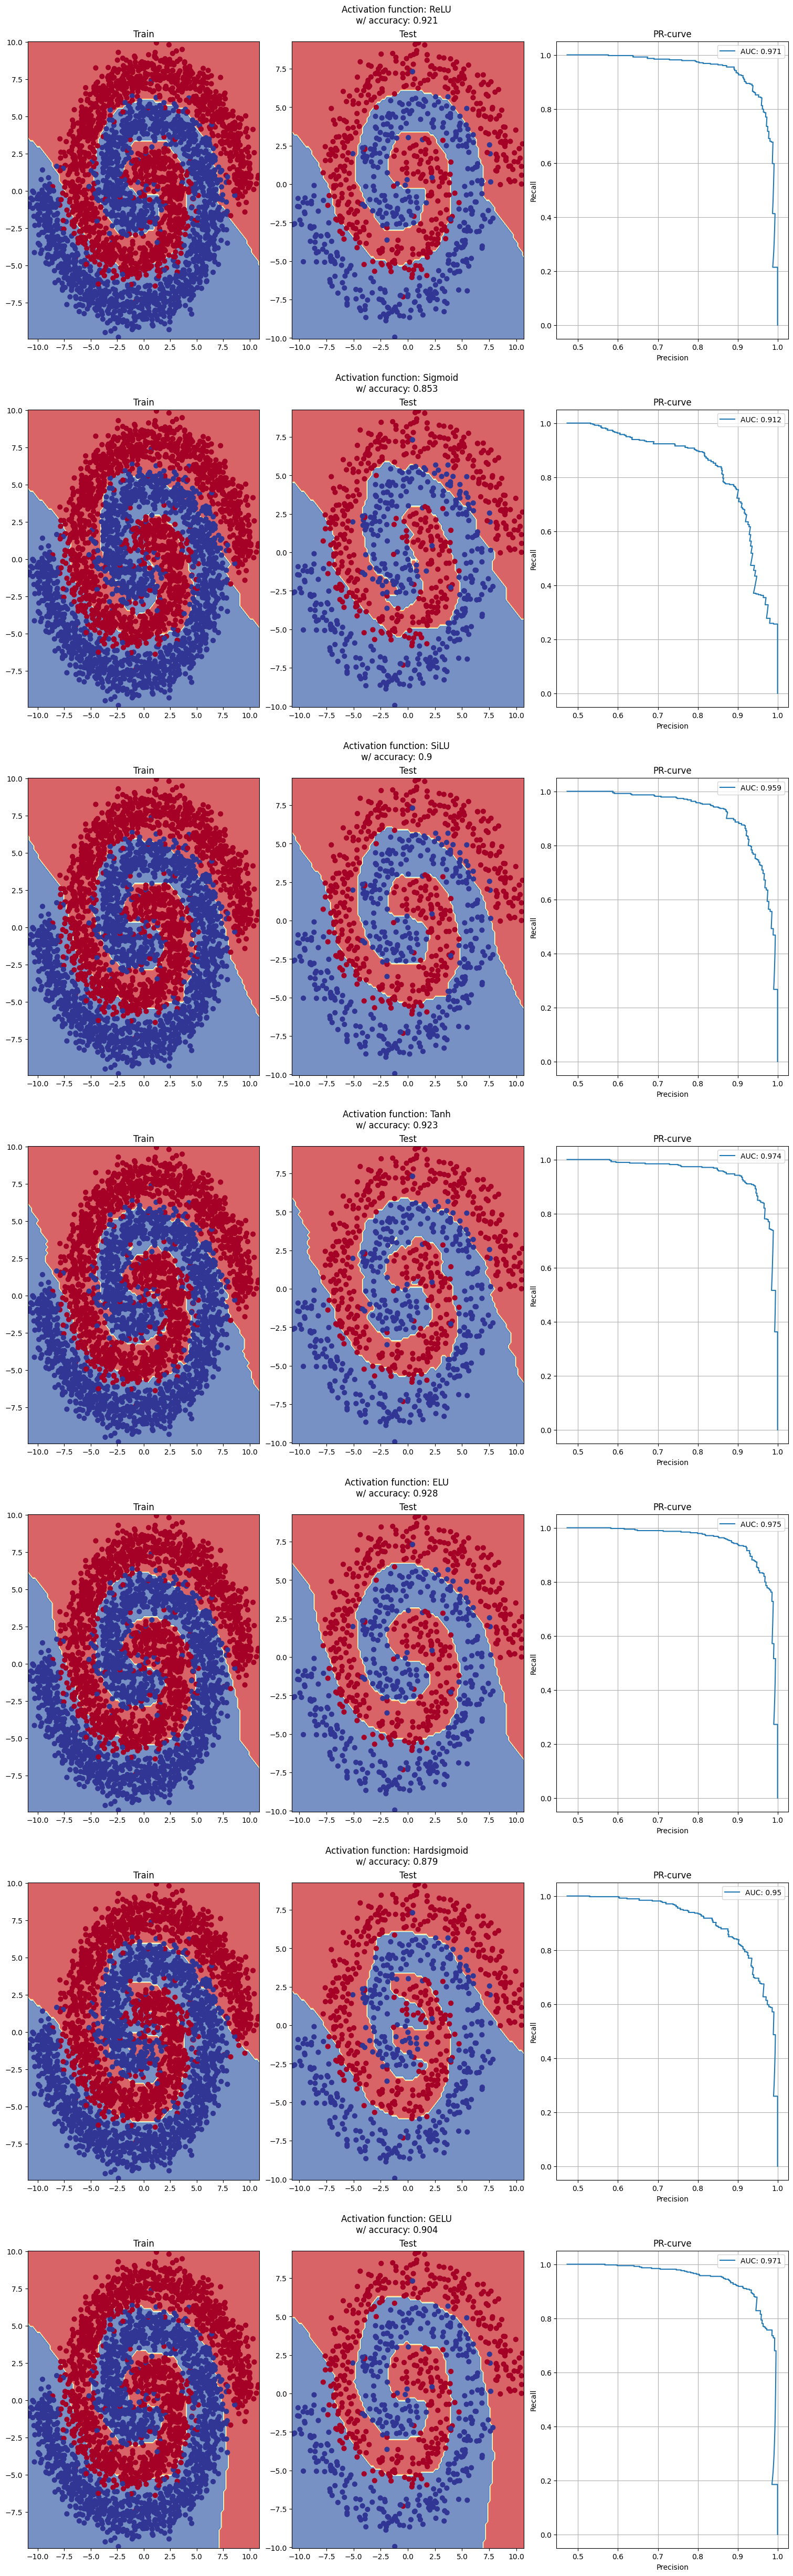

In [26]:
model_object_dict = utilities.run_model(
    activation_functions=activation_functions, **model_kwargs, **data_kwargs
)

## Plot transformation of X points through time stepping

In [27]:
plot_model = model_object_dict["ReLU"]

### 3D plot for each time step (works well for hidden dim = 3)

In [28]:
utilities.plot_transformation_3d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    static=False,
    interactive=True,
)

### Plot 2D with PCA to reduce dimension

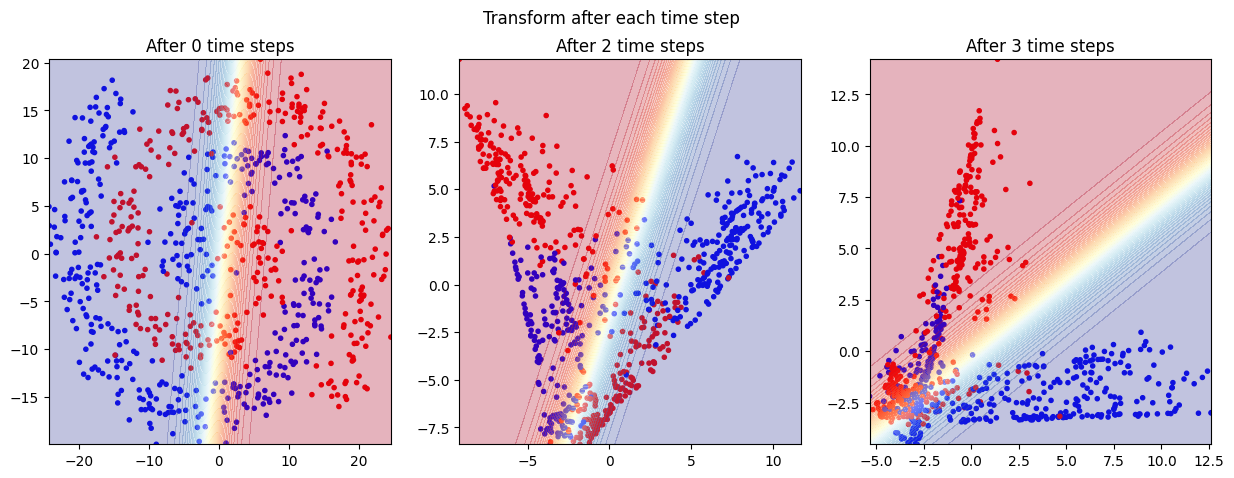

In [29]:
utilities.plot_transformation_2d(
    x_transformed_reduced=plot_model.x_transformed_reduced,
    color_transformed_reduced=plot_model.color_transformed_reduced,
    show_decision_boundary=True,
    model=plot_model,
)

## Loss, accuracy and confusion matrix

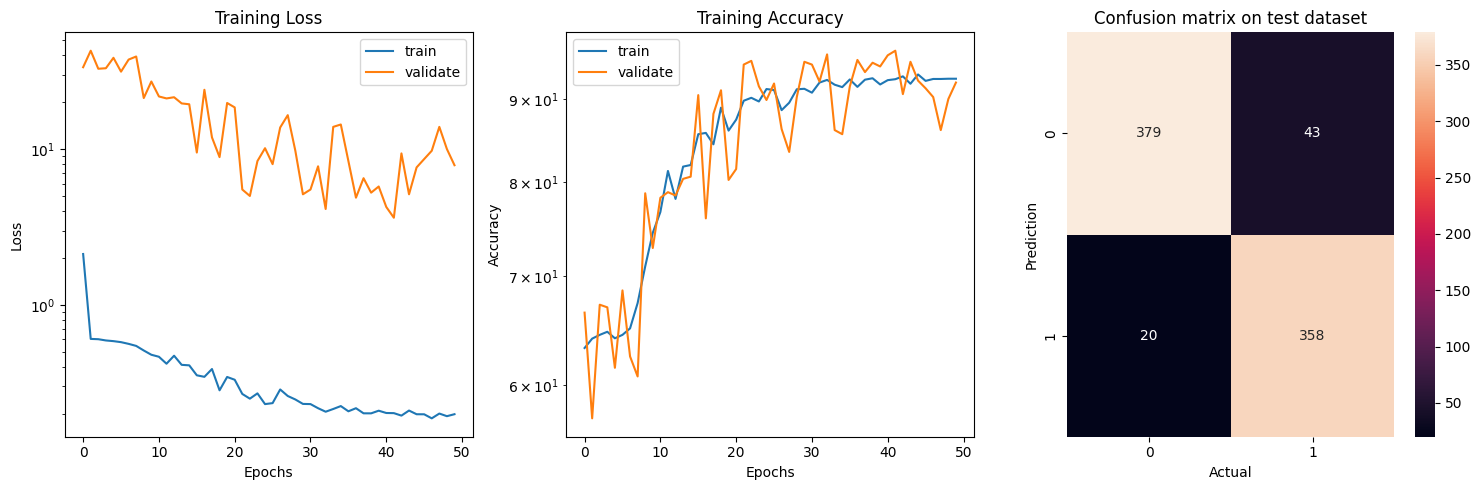

In [30]:
# plot loss, acc, cm
utilities.plot_evaluation_score(
    plot_model.train_loss_per_epoch,
    plot_model.test_loss_per_epoch,
    plot_model.train_acc_per_epoch,
    plot_model.test_acc_per_epoch,
    plot_model.confusion_matrix,
)